In [48]:
import sys
sys.path.append("..")

import time
from enum import Enum
import torch
from utils import compute_min_max
import matplotlib.pyplot as plt

# Import dataset loaders
from dataset_loaders.MNIST import get_MNIST
from dataset_loaders.FASHION_MNIST import get_FASHION_MNIST
from dataset_loaders.CIFAR import get_CIFAR

# Import architectures
from architectures.CKAN_LIN import *

# Use this file to conduct our experiments

### First check if we can run on GPU:

In [45]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


### Select the dataset:

In [46]:
class Dataset(Enum):
    MNIST = 1
    FASH_MNIST = 2
    CIFAR = 3
    TINY_IMAGENET = 4

    def get_dataset(self, fraction, batch_size):
        if self == Dataset.MNIST:
            return get_MNIST(fraction, batch_size)
        elif self == Dataset.FASH_MNIST:
            return get_FASHION_MNIST(fraction, batch_size)
        elif self == Dataset.CIFAR:
            return get_CIFAR(fraction, batch_size)
        elif self == Dataset.TINY_IMAGENET:
            return "Not implemented"
        else:
            return "Unknown option"

In [47]:
# Change enum to pick different dataset
dataset = Dataset.MNIST

# Set the required variables
fraction = 0.001
batch_size = 32

train_val_dataset, test_dataset, train_loader, test_loader = dataset.get_dataset(fraction, batch_size)

### Select which architecture we want to use:

In [39]:
class Archicture(Enum):
    CKAN_KAN = 1
    CKAN_LIN = 2
    CNN_KAN  = 3 
    CNN_LIN  = 4

    def get_architecture(self, channels, out_features, min_grid, device):
        if self == Archicture.CKAN_KAN:
            return "Not implemented"
        elif self == Archicture.CKAN_LIN:
            return CKANNet(channels, out_features, grid=min_grid, device=device).to(device)
        elif self == Archicture.CNN_KAN:
            return "Not implemented"
        elif self == Archicture.CNN_LIN:
            return "Not implemented"
        else:
            return "Unknown option"

In [40]:
# Change enum to pick different architecture
archicture = Archicture.CKAN_LIN

# Architecture parameters
channels = [1, 2, 3]
out_features = 10

# Training parameters
learning_rate = 0.01
num_epochs = 50

# Grid parameters
min_grid = 1
max_grid, curr_grid = 13, min_grid
grid_range = compute_min_max(train_val_dataset)
step = 4
grid_update_freq = int(num_epochs / ((max_grid - min_grid) / step + 1e-5))

net = archicture.get_architecture(channels, out_features, min_grid, device)

In [41]:
# Optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Define metrics:

TODO: add more metrics

In [42]:
def evaluate_accuracy(data_loader, net, device=torch.device('cuda:0')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

### Run the training loop:

In [43]:
# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

epoch_times = []
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Cannot get grid extension to work with current CKAN setup :-(
    if (epoch + 1) % grid_update_freq == 0 and curr_grid < max_grid and epoch > 0:
        curr_grid += step
        print(f"Updating grid to {curr_grid} in epoch {epoch+1}")
        net.update_grid(curr_grid)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Network in training mode and to device
    net.train()

    # Training loop
    for x_batch, y_batch in train_loader:
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = net(x_batch)

        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100 * evaluate_accuracy(train_loader, net.to(device), device)
    test_acc = 100 * evaluate_accuracy(test_loader, net.to(device), device)

    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print(f'Epoch: {epoch+1}')
    print('Accuracy of train set: {:.1f}%'.format(train_acc))
    print('Accuracy of test set: {:.1f}%'.format(test_acc))
    print('')

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)


total_time = time.time() - start_time
avg_epoch_time = np.mean(epoch_times)

print(f"Total training time: {total_time:.2f} seconds")
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")

Epoch: 1
Accuracy of train set: 16.7%
Accuracy of test set: 0.0%

Epoch: 2
Accuracy of train set: 31.7%
Accuracy of test set: 10.0%

Epoch: 3
Accuracy of train set: 20.0%
Accuracy of test set: 0.0%

Epoch: 4
Accuracy of train set: 33.3%
Accuracy of test set: 10.0%

Epoch: 5
Accuracy of train set: 63.3%
Accuracy of test set: 50.0%

Epoch: 6
Accuracy of train set: 78.3%
Accuracy of test set: 50.0%

Epoch: 7
Accuracy of train set: 88.3%
Accuracy of test set: 70.0%

Epoch: 8
Accuracy of train set: 90.0%
Accuracy of test set: 70.0%

Epoch: 9
Accuracy of train set: 95.0%
Accuracy of test set: 80.0%

Epoch: 10
Accuracy of train set: 93.3%
Accuracy of test set: 70.0%

Epoch: 11
Accuracy of train set: 98.3%
Accuracy of test set: 70.0%

Epoch: 12
Accuracy of train set: 100.0%
Accuracy of test set: 70.0%

Epoch: 13
Accuracy of train set: 100.0%
Accuracy of test set: 70.0%

Epoch: 14
Accuracy of train set: 100.0%
Accuracy of test set: 70.0%

Epoch: 15
Accuracy of train set: 100.0%
Accuracy of test

### Results & Visualizations:

TODO: add more visualizations

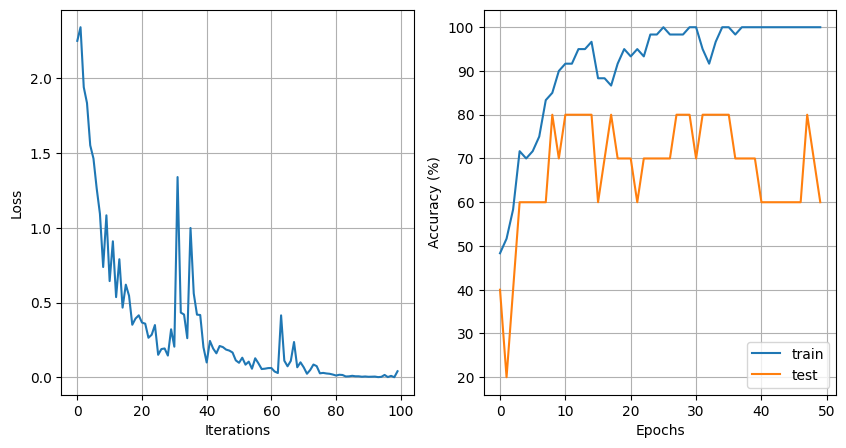

In [30]:
# Assuming 'train_losses' is a list of tensors
train_losses_detached = [loss.detach().cpu().numpy() for loss in train_losses]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_detached)  # Use the detached list of numpy arrays
plt.grid()

# Assuming you have additional plots or other code to follow
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()